# Movie Review Classification: Machine Learning for Texts

The *Film Junky Union*, a new community for classic movie enthusiasts, wants to automate the filtering and categorization of movie reviews. The goal is to train a model capable of automatically classifying reviews as positive or negative.

To achieve this, we will use an IMDb dataset containing reviews labeled by polarity. Our objective is to develop and evaluate different text processing and machine learning approaches to achieve an **F1-score of at least 0.85**.

This project will demonstrate fundamental NLP (*Natural Language Processing*) skills, including **text preprocessing, vectorization, machine learning, and model evaluation**.

## Data Description

The data is stored in the file `imdb_reviews.tsv`.

The dataset was provided by **Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts** (2011) in the paper *Learning Word Vectors for Sentiment Analysis*, presented at the 49th Annual Meeting of the *Association for Computational Linguistics* (ACL 2011).

### Selected Fields:

- **review**: the text of the review.
- **pos**: the polarity of the review, where `'0'` indicates negative and `'1'` indicates positive.
- **ds_part**: indicates the part of the dataset, where `'train'` is for training and `'test'` is for testing.

There are other fields in the dataset. Feel free to explore them if you wish.

## Initialization

In [1]:
# Essential imports

# Data manipulation
import os
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Progress bar
from tqdm.auto import tqdm

# Natural Language Processing (NLP)
import re
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import spacy

# Ensure necessary NLTK resources are available
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Machine Learning
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix

# Advanced Models
import torch
import transformers
from lightgbm import LGBMClassifier

print("Libraries loaded successfully.")

[nltk_data] Downloading package punkt to C:\Users\bruno/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bruno/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\bruno/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\bruno/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Libraries loaded successfully.


In [2]:
# General configurations
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Better quality for HiDPI screens
plt.style.use('seaborn-v0_8-whitegrid')

In [3]:
# Enable progress bar in Pandas
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
# Display the first rows for inspection with separator
print(df_reviews.head(), end="\n\n" + "-" * 100 + "\n")

# Display general information about the dataset
print(df_reviews.info(), end="\n\n" + "-" * 100 + "\n")

# Statistical summary of numerical columns
print(df_reviews.describe(include='all'), end="\n\n" + "-" * 100 + "\n")

      tconst title_type primary_title original_title  start_year end_year  \
0  tt0068152      movie             $              $        1971       \N   
1  tt0068152      movie             $              $        1971       \N   
2  tt0313150      short          '15'           '15'        2002       \N   
3  tt0313150      short          '15'           '15'        2002       \N   
4  tt0313150      short          '15'           '15'        2002       \N   

  runtime_minutes  is_adult              genres  average_rating  votes  \
0             121         0  Comedy,Crime,Drama             6.3   2218   
1             121         0  Comedy,Crime,Drama             6.3   2218   
2              25         0  Comedy,Drama,Short             6.3    184   
3              25         0  Comedy,Drama,Short             6.3    184   
4              25         0  Comedy,Drama,Short             6.3    184   

                                              review  rating   sp  pos  \
0  The pakage impl

## Initial Data Analysis

### General Observations
The dataset contains **47,331 movie reviews**, with information on title, release year, duration, genres, and ratings. Additionally, reviews are labeled as **positive (1) or negative (0)** for machine learning purposes.

### Dataset Structure
- The dataset consists of **17 columns**, including:
  - **Identification fields:** `tconst` (IMDb ID)
  - **Movie metadata:** `title_type`, `primary_title`, `original_title`, `start_year`, `end_year`, `runtime_minutes`, `genres`
  - **Numerical features:** `average_rating`, `votes`
  - **Review text:** `review`
  - **Labeling:** `rating`, `pos`
  - **Dataset split:** `ds_part` (`train` or `test`)

### Possible Issues Identified
1. **Missing values and inconsistencies:**
   - **`end_year`** contains `\N` values, indicating possible missing data.
   - **`runtime_minutes`** is stored as `object` instead of a numerical value.
   - **`average_rating` and `votes`** have **two missing values**.

2. **Class distribution (`pos`):**
   - The classification is **balanced** (~50% positive and ~50% negative), which is beneficial for machine learning models.

3. **Characteristics of review text:**
   - The `review` column contains **47,240 unique texts**, indicating a small amount of duplication.

### Impact on Next Steps
- **Text preprocessing:** Duplicate removal and missing value handling will be required before modeling.
- **Type conversion:** `runtime_minutes` and `end_year` need to be converted to numerical values.
- **Possible feature engineering:** `genres`, `title_type`, and `average_rating` could be useful for improving predictions.

In [6]:
# Identify potential duplicates considering title, year, and review
duplicates = df_reviews.duplicated(subset=['primary_title', 'start_year', 'review'], keep=False)
print(f"Potential duplicate records: {duplicates.sum()}")

# Remove only exact duplicates (if any exist)
df_reviews = df_reviews.drop_duplicates(subset=['primary_title', 'start_year', 'review'])
print(f"Total records after duplicate removal: {df_reviews.shape[0]}")

Potential duplicate records: 169
Total records after duplicate removal: 47242


In [7]:
# Replace '\N' with NaN to facilitate handling
df_reviews.replace('\\N', np.nan, inplace=True)

# Convert runtime_minutes and end_year to numeric values
df_reviews['runtime_minutes'] = pd.to_numeric(df_reviews['runtime_minutes'], errors='coerce')
df_reviews['end_year'] = pd.to_numeric(df_reviews['end_year'], errors='coerce')

# Check for missing values after conversion
print(df_reviews[['runtime_minutes', 'end_year']].isna().sum())

runtime_minutes      488
end_year           44969
dtype: int64


## Exploratory Data Analysis (EDA)

### Temporal and Review Distribution
We will analyze the temporal distribution of movies and reviews to understand:
1. The evolution of movie volume over time.
2. The distribution of positive and negative reviews.
3. The average number of reviews per movie in different periods.

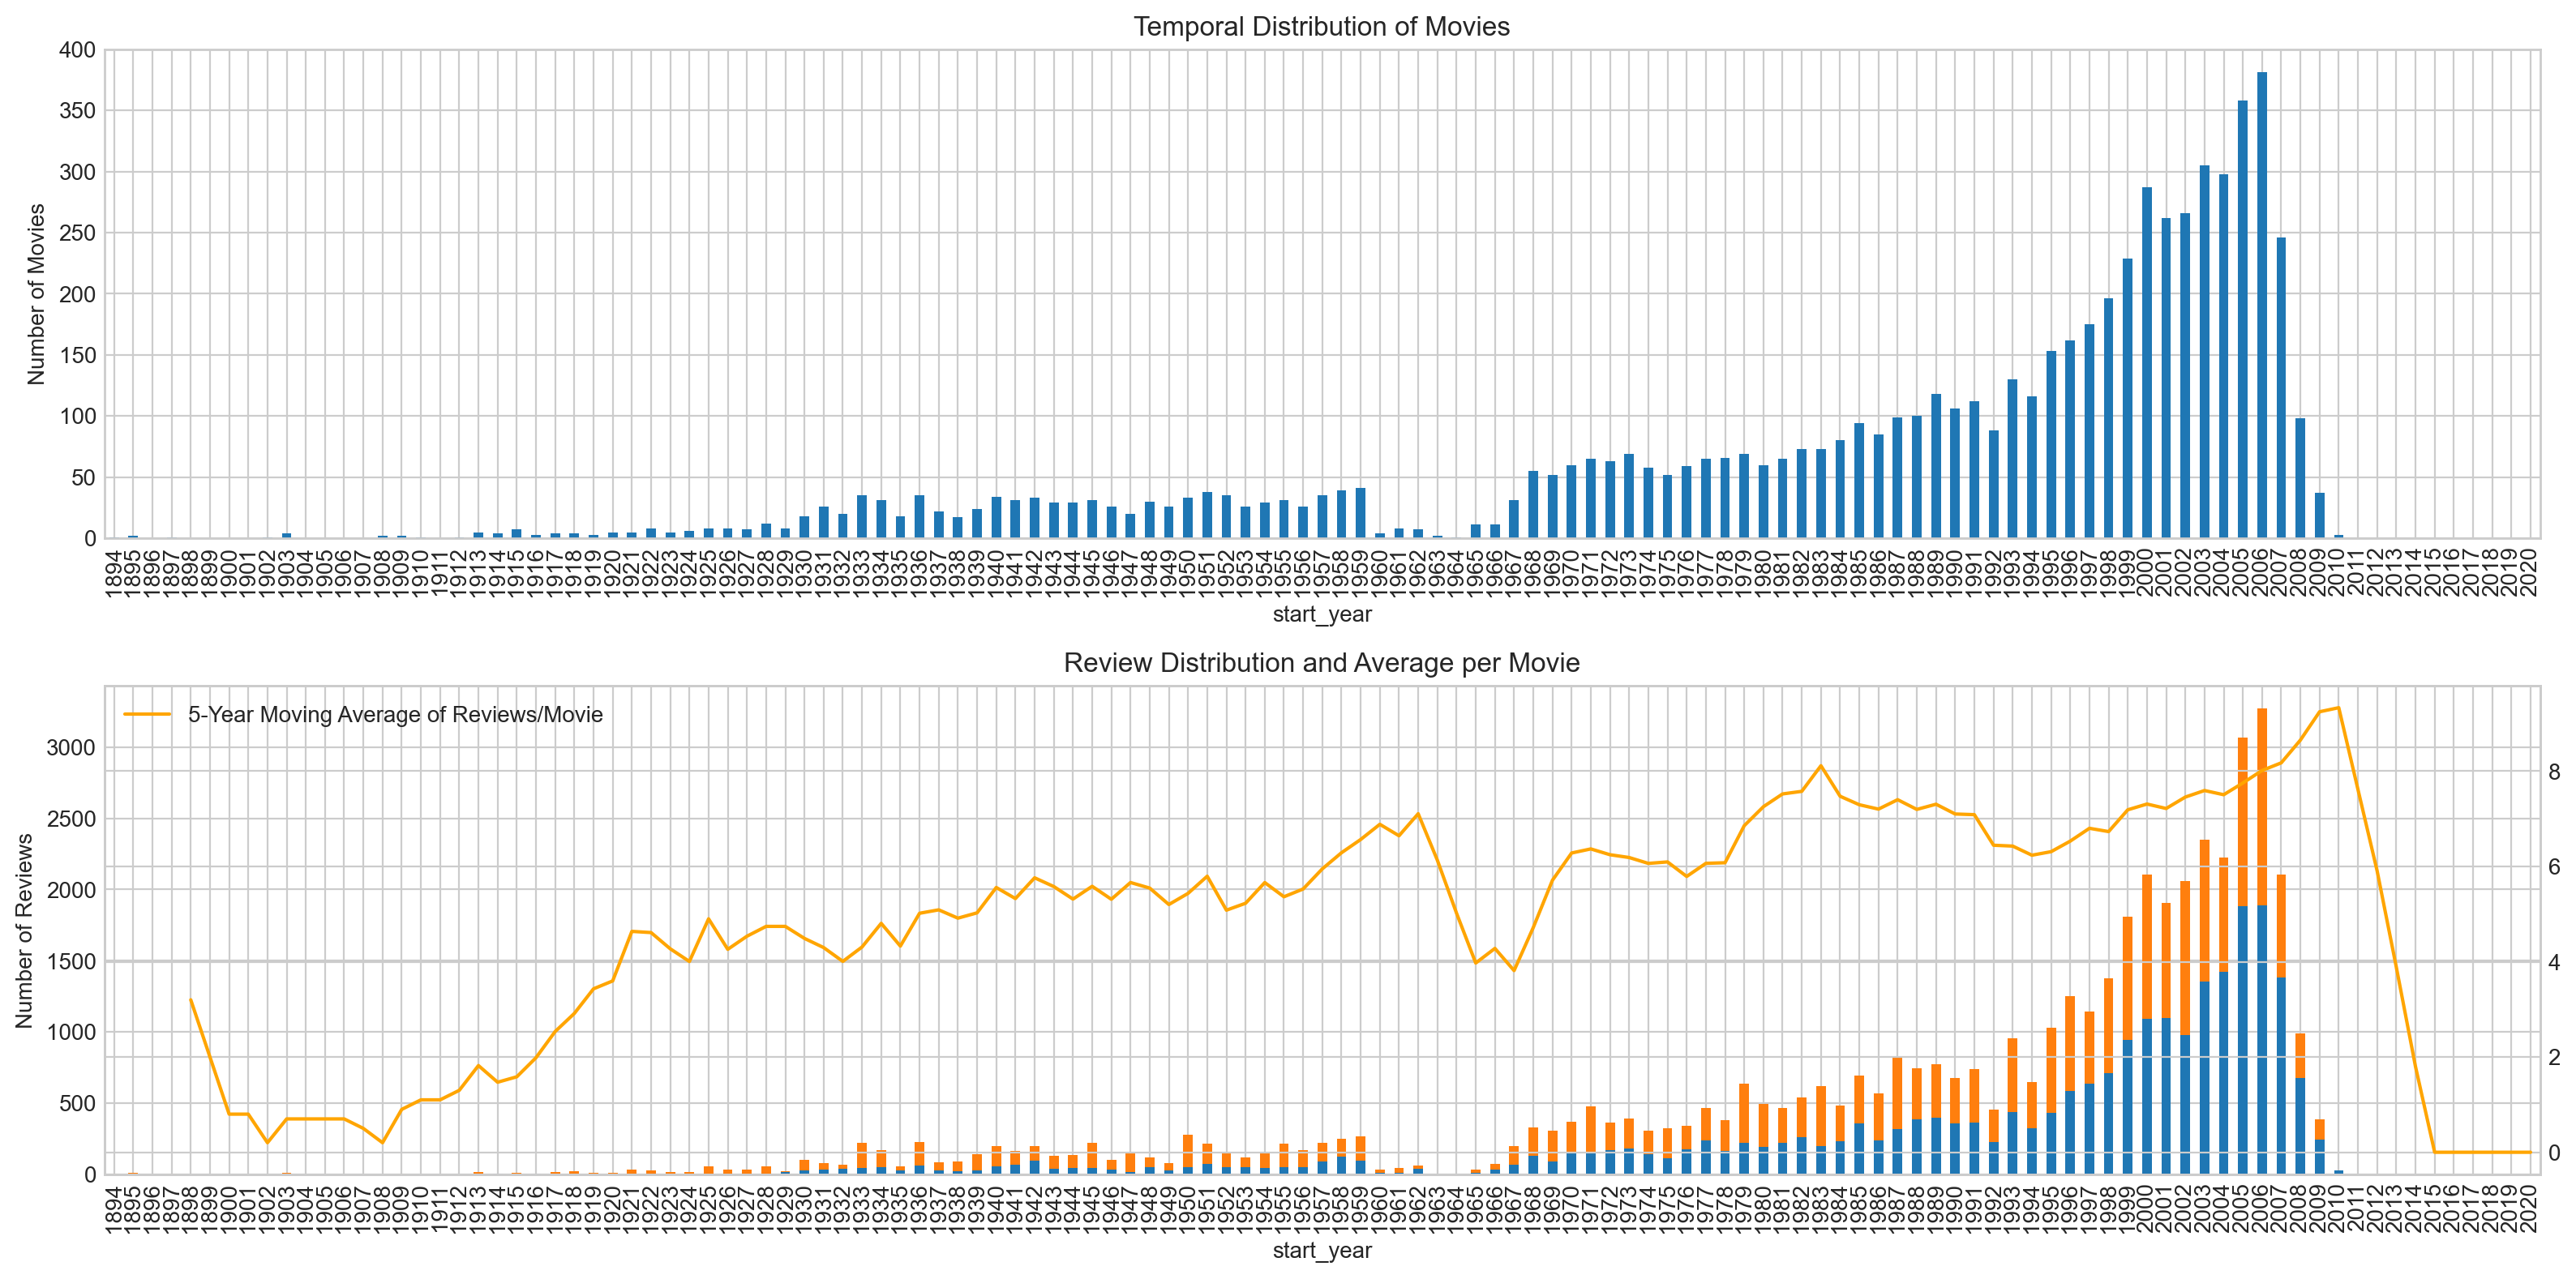

In [8]:
# Subplot configuration
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

# Top plot: Number of movies per year
ax = axs[0]
dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Temporal Distribution of Movies')
ax.set_ylabel('Number of Movies')

# Bottom plot: Reviews per year and polarity
ax = axs[1]
dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft2.plot(kind='bar', stacked=True, label=['Negative', 'Positive'], ax=ax)

# Moving average of reviews per movie
dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', 
    label='5-Year Moving Average of Reviews/Movie', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')
ax.set_title('Review Distribution and Average per Movie')
ax.set_ylabel('Number of Reviews')

plt.tight_layout()

### Observations from the Temporal Analysis:

1. **Cinematic Production**:
  - Consistent growth over the decades, with a sharp increase between 1980 and 2000.
  - Peak production in 2008.
  - Gradual decline after 2008, possibly reflecting changes in the industry or data collection methodology.

2. **Review Volume**:
  - Directly follows the movie production pattern.
  - Highest concentration of reviews between 1990 and 2008.
  - Balanced proportion between positive and negative reviews.
  - Engagement peaks coincide with periods of higher movie production.

3. **Average Reviews per Movie**:
  - Represented by the orange line, showing fluctuations over the years.
  - Maintains a general growth trend despite oscillations.
  - Indicates increasing audience engagement even with fewer movies.
  - Suggests greater user interaction in movie reviews.

These trends demonstrate a clear evolution in both the volume of cinematic production and public interest in reviewing movies, especially between the 1980s and 2000s. The decline after 2008 may reflect structural changes in the industry or modifications in data collection methodology.

---

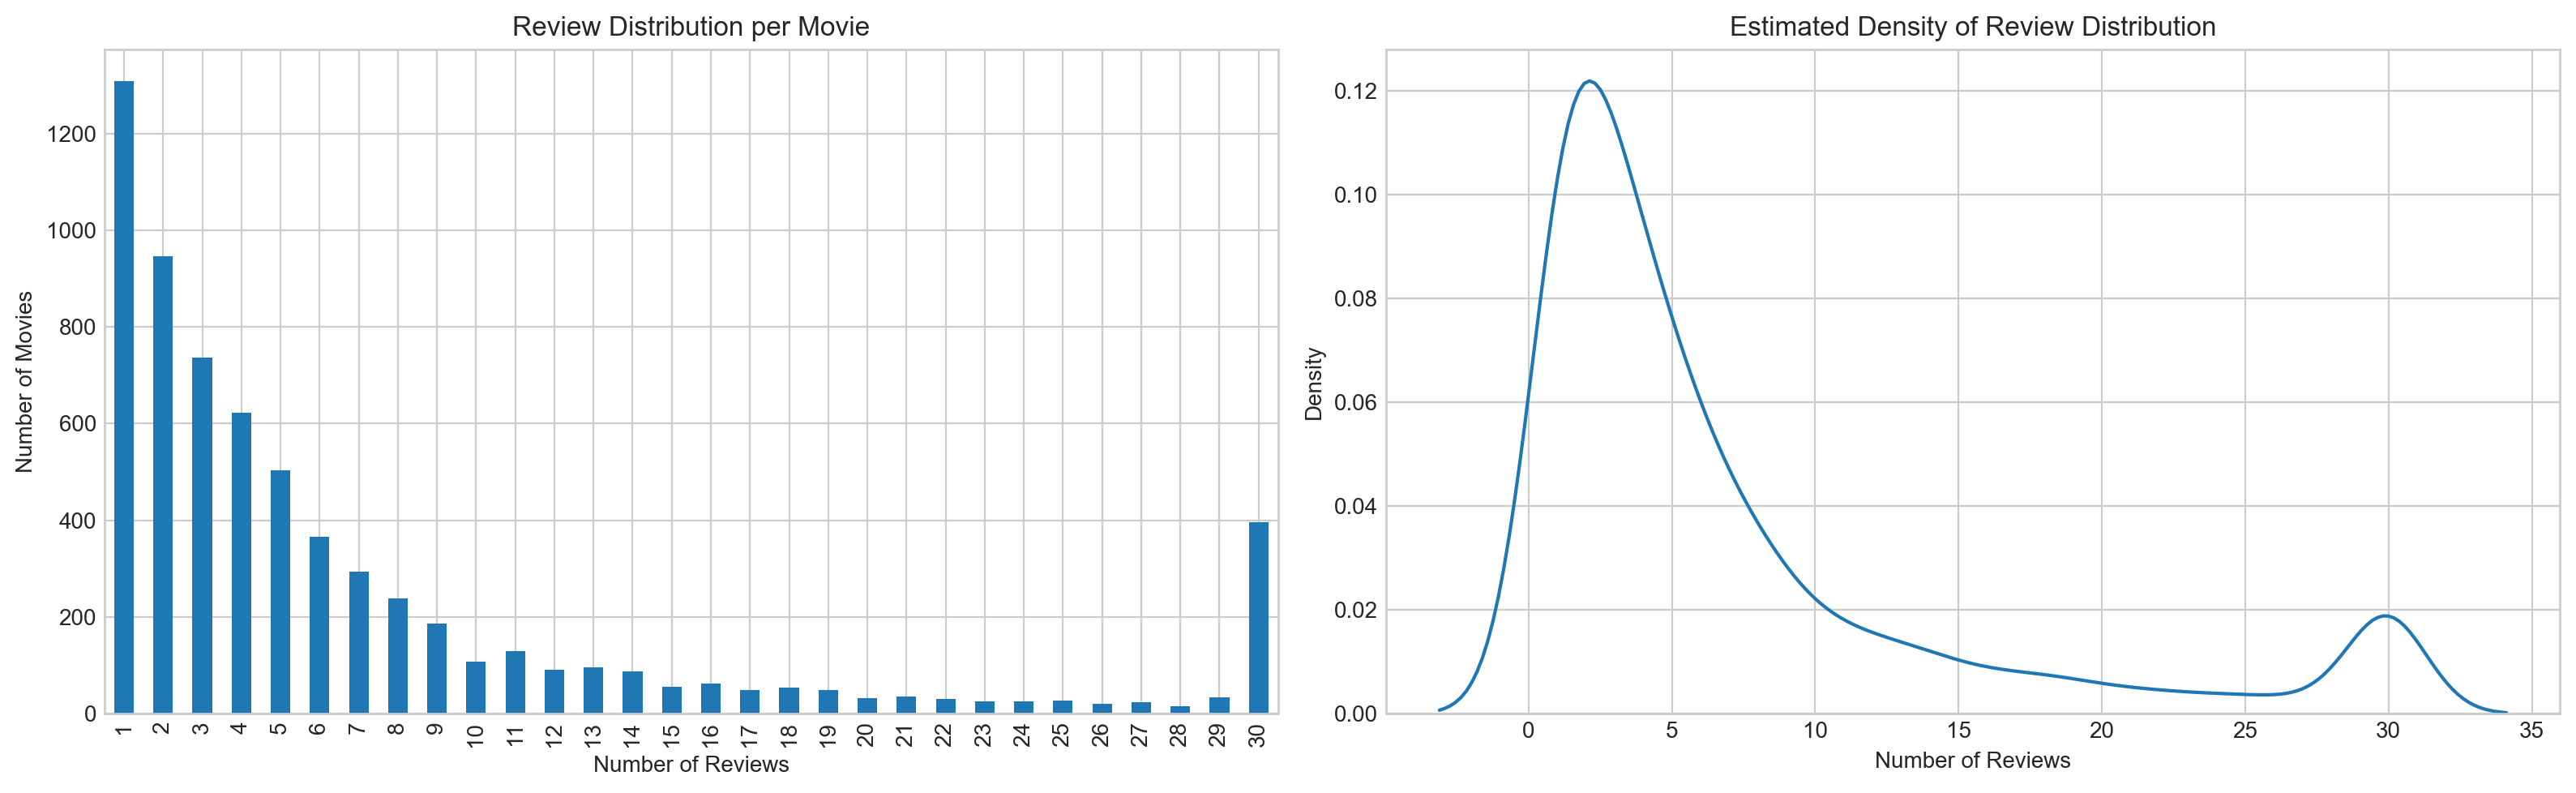

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Bar Chart: Review Count
ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Review Distribution per Movie')
ax.set_xlabel('Number of Reviews')
ax.set_ylabel('Number of Movies')

# KDE: Smoothed Distribution
ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Estimated Density of Review Distribution')
ax.set_xlabel('Number of Reviews')
ax.set_ylabel('Density')

fig.tight_layout()

### Analysis of Review Distribution per Movie

We will analyze the distribution of the number of reviews per movie using two complementary approaches:

1. **Exact Count**: A bar chart showing the actual frequency of reviews per movie.
2. **Kernel Density Estimation (KDE)**: A non-parametric method that smooths the distribution, allowing us to visualize underlying patterns that may not be evident in raw counts.

KDE is particularly useful in this context because:
- It reduces noise from discrete data.
- It helps identify key distribution characteristics.
- It allows better visualization of the overall shape of the distribution.

### Distribution Observations:

1. **Review Concentration**:
  - Strong positive skew in the distribution.
  - Most movies receive very few reviews (1-2).
  - Exponential decline in frequency as the number of reviews increases.

2. **Visualization Analysis**:
  - **Bar Chart**:
    - Clearly shows a concentration in movies with very few reviews.
    - Demonstrates a gradual decrease in frequency as the number of reviews increases.
  - **KDE**:
    - Confirms the pattern of concentration in low review numbers.
    - Reveals a small secondary peak, suggesting a subgroup of popular movies.

3. **Implications for the Model**:
  - The data presents a bias toward less popular movies.
  - A small subset of movies attracts a disproportionately high number of reviews.
  - This imbalance must be considered when developing the classification model.

This dual analysis helps us better understand the data structure and identify potential challenges for developing the classification model.

---

### Analysis of Polarity Distribution

We will examine the distribution of positive and negative ratings in the training and testing sets to:
1. Check the balance between classes.
2. Evaluate the consistency of the distribution across the sets.
3. Identify potential biases in the data split.

In [10]:
df_reviews['pos'].value_counts()

pos
0    23680
1    23562
Name: count, dtype: int64

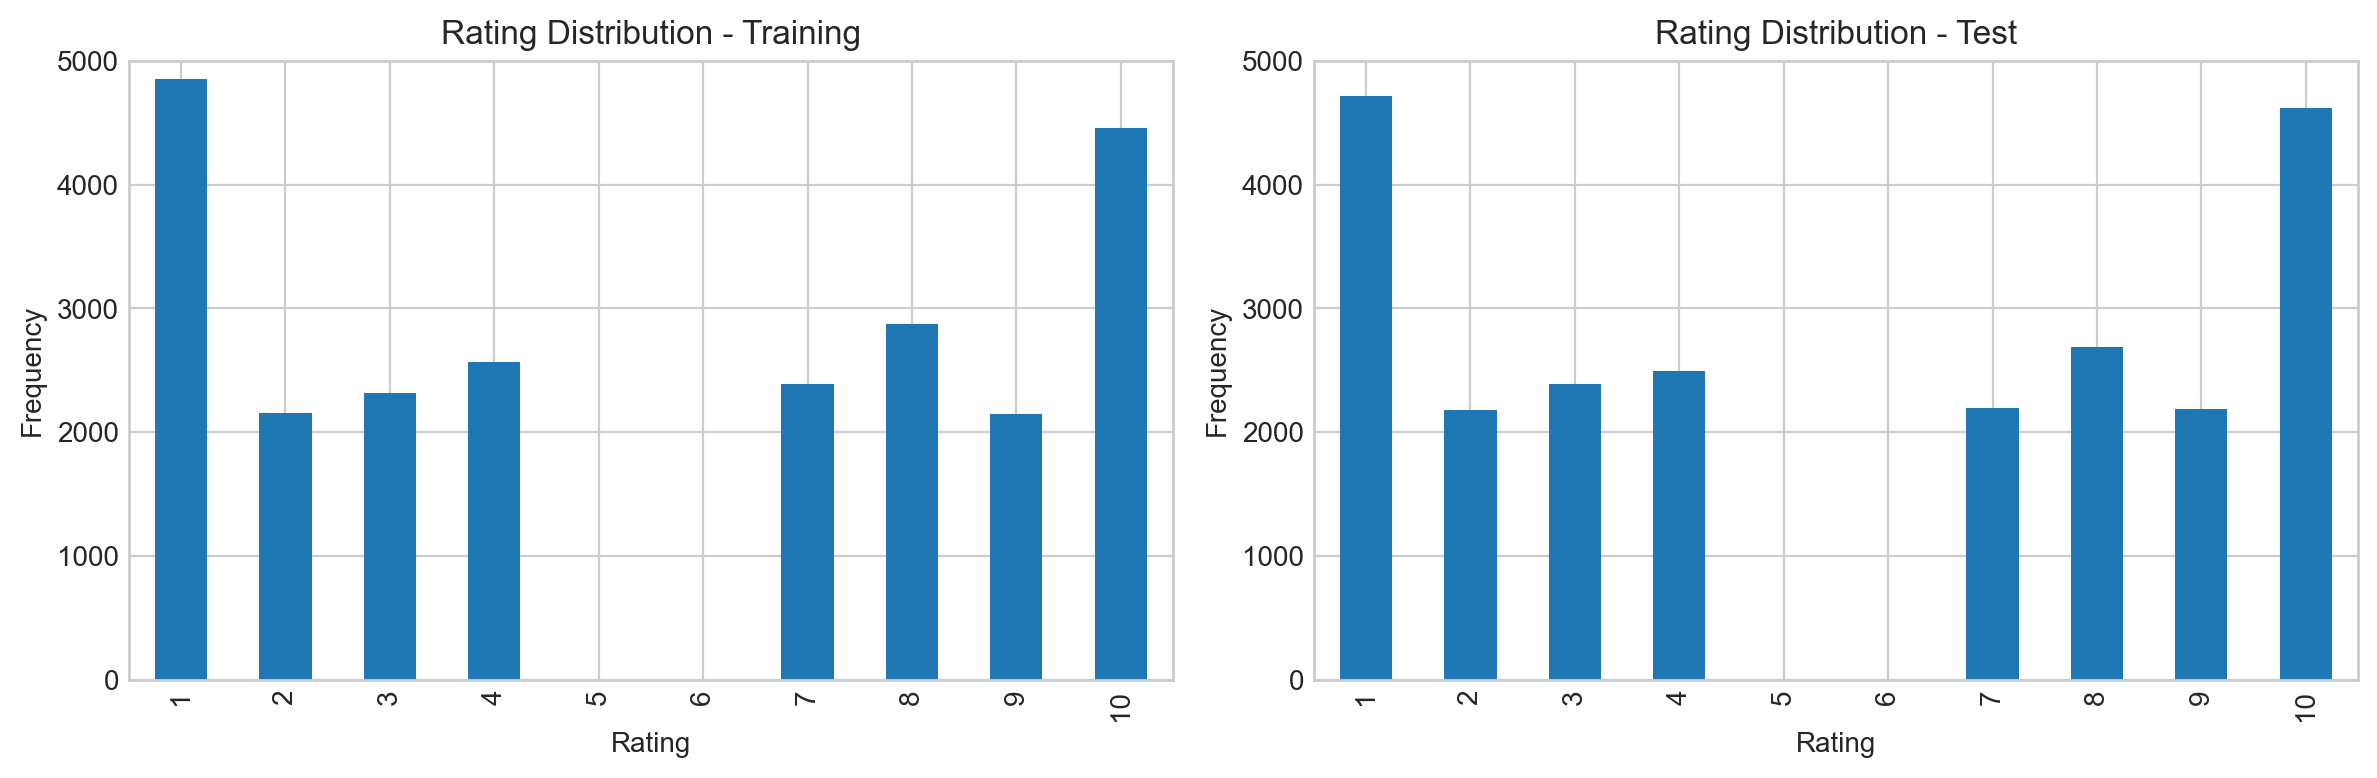

In [11]:
# Visualization of distribution in training and test sets
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Training Set
ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Rating Distribution - Training')
ax.set_xlabel('Rating')
ax.set_ylabel('Frequency')

# Test Set
ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Rating Distribution - Test')
ax.set_xlabel('Rating')
ax.set_ylabel('Frequency')

fig.tight_layout()

### Observations on Polarity Distribution by Data Set:

1. **Training Set:**
  - Shows a balanced distribution between positive and negative reviews.
  - Extreme ratings (1 and 10) are the most frequent.
  - Clear evidence of polarization in the reviews, a common feature in movie ratings.

2. **Test Set:**
  - Replicates the distribution pattern of the training set.
  - Similar predominance of extreme ratings (1 and 10).
  - Demonstrates consistency in data splitting, with no significant bias between training and test sets.

3. **General Analysis:**
  - The predominance of extreme ratings indicates a characteristic pattern in movie reviews.
  - Users tend to express strongly positive or negative opinions.
  - Lower occurrence of intermediate ratings suggests clearer decisions in polarity.

4. **Implications for Modeling:**
  - The consistent distribution favors model generalization.
  - The natural polarization of ratings may facilitate binary classification.
  - Proper splitting between training and testing suggests good representativeness for validation.

This analysis indicates a favorable scenario for the development of the classification model, with well-distributed data and clear polarity patterns.

---

### Temporal Analysis of Polarity Distribution

We will examine the distribution of positive and negative reviews over time for each dataset, allowing us to:
1. Visualize temporal trends in polarity.
2. Compare distributions between training and test sets.
3. Identify possible polarity patterns per movie.

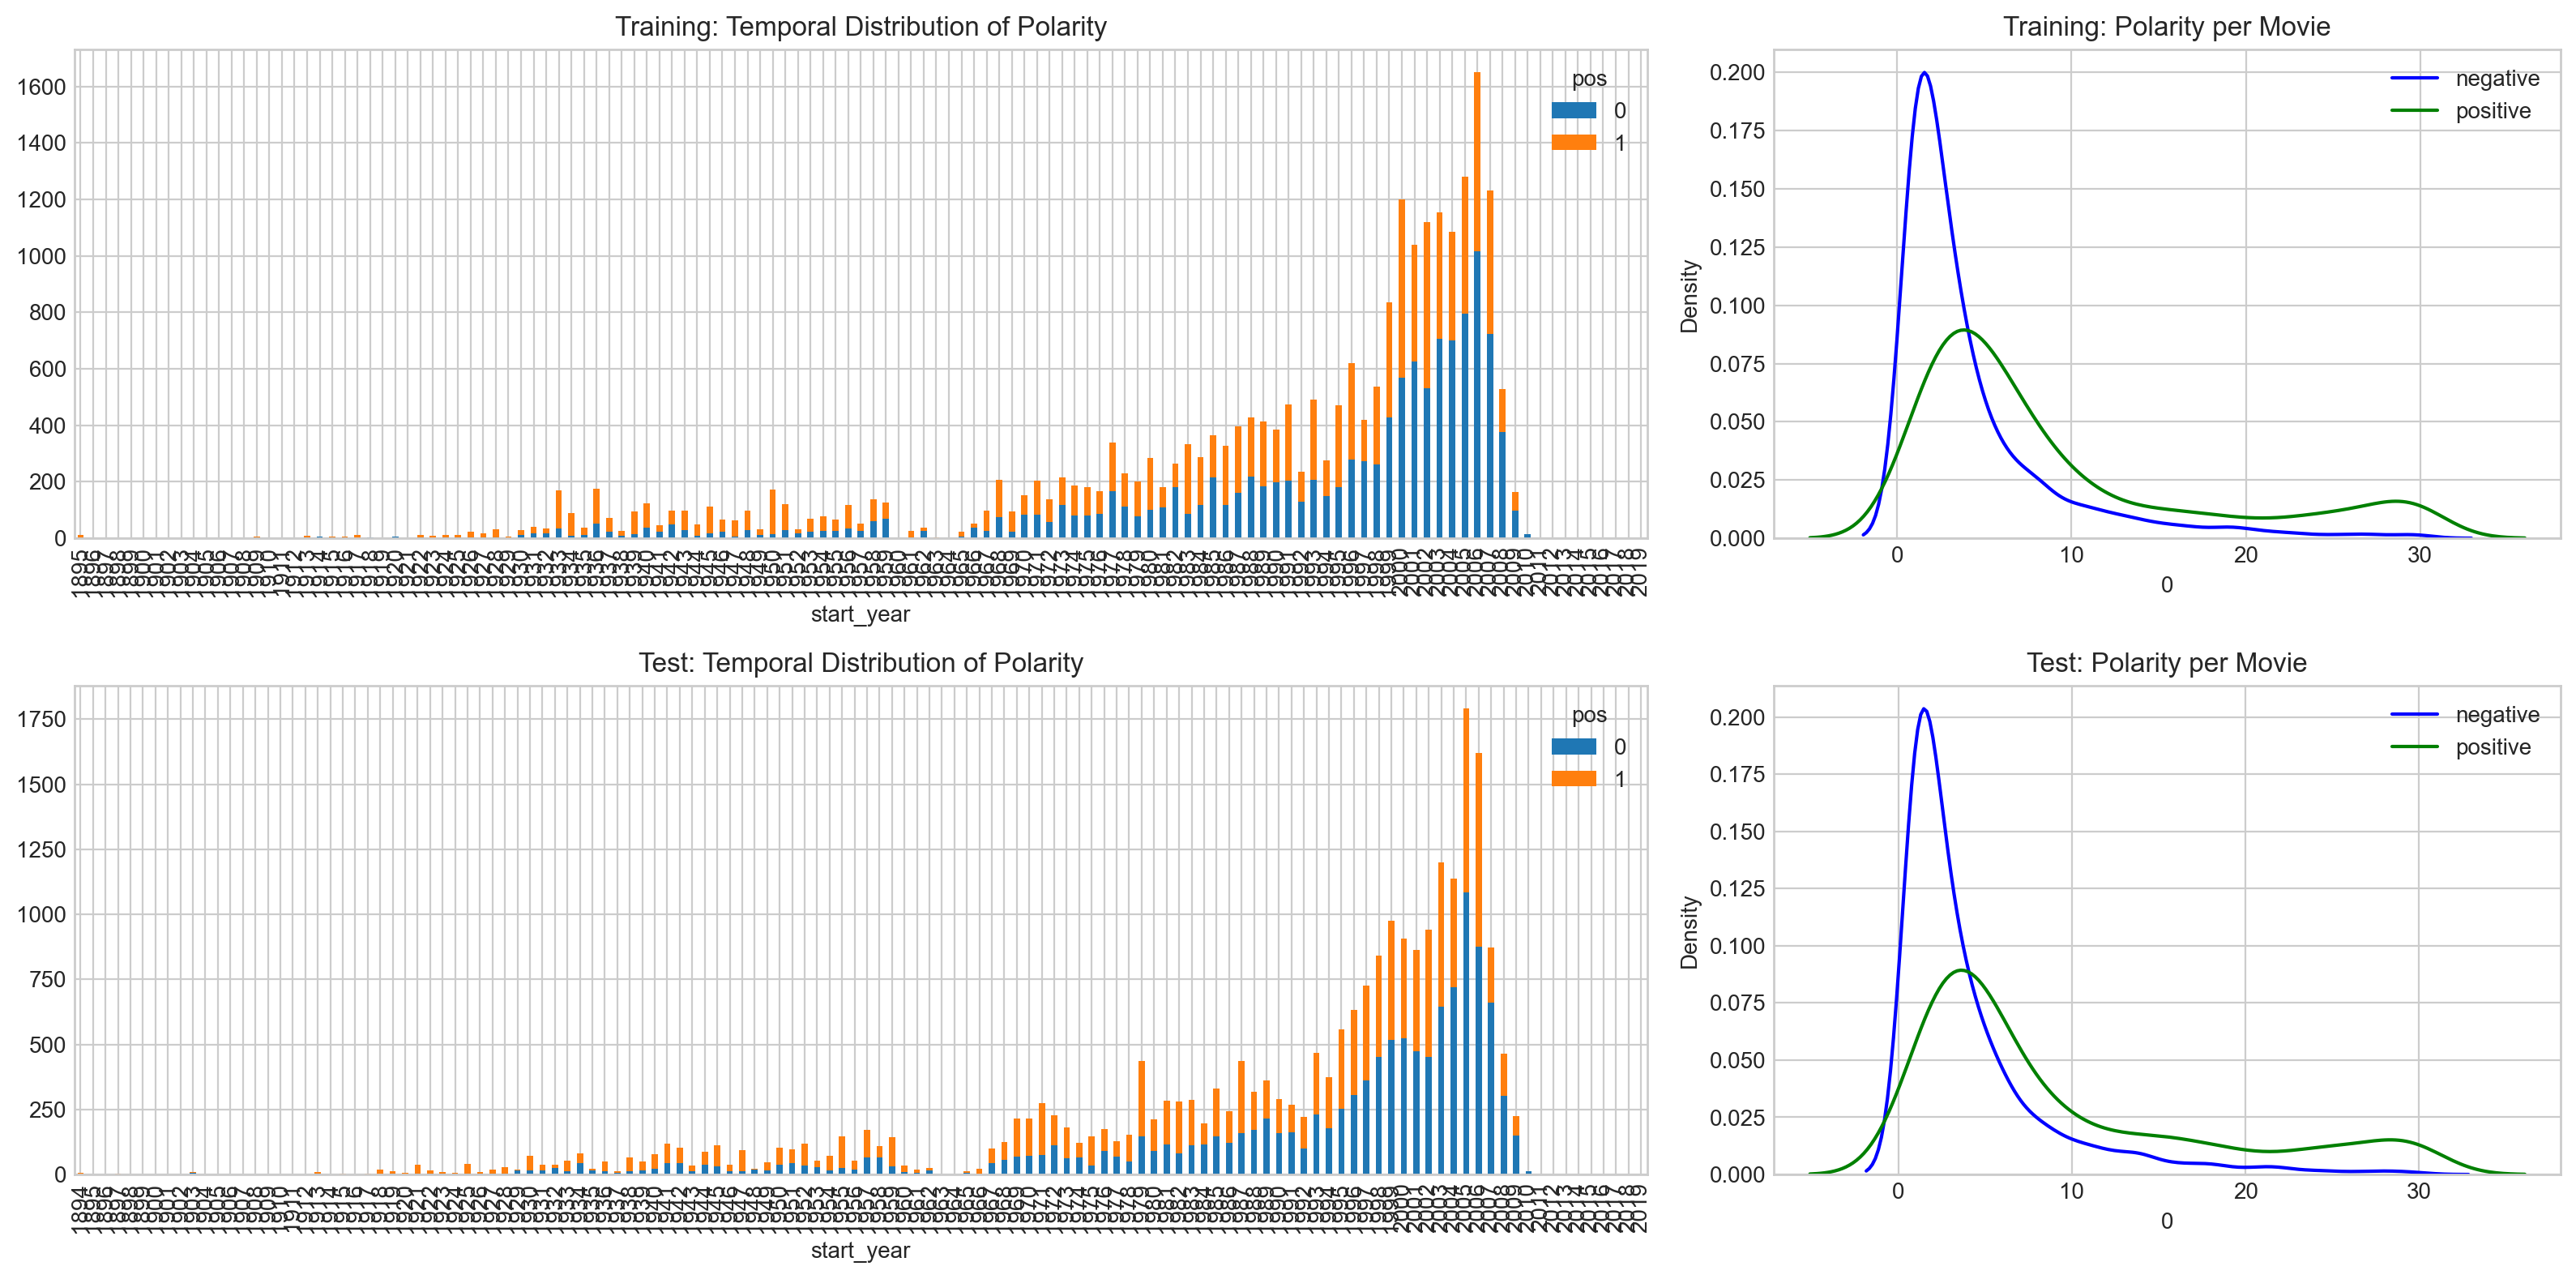

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

# Training Set - Temporal Distribution
ax = axs[0][0]
dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Training: Temporal Distribution of Polarity')

# Training Set - Distribution per Movie
ax = axs[0][1]
dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('Training: Polarity per Movie')

# Test Set - Temporal Distribution
ax = axs[1][0]
dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Test: Temporal Distribution of Polarity')

# Test Set - Distribution per Movie
ax = axs[1][1]
dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('Test: Polarity per Movie')

fig.tight_layout()

### Temporal Analysis of Polarity Distribution

The graphs represent the distribution of negative and positive reviews over the years, allowing for a comparative analysis between the training and test sets.

### Detailed Observations:

1. **Training Set: Number of Reviews per Year (Top Left Graph):**
  - Consistent growth in both polarities, with a significant increase after 1980.
  - Positive reviews maintain a slight predominance in most periods.
  - Growth pattern aligned with the evolution of the film industry.

2. **Polarity Distribution per Movie in Training (Top Right Graph):**
  - The density of negative reviews presents a sharper peak.
  - Movies with fewer reviews tend to accumulate more negative evaluations.
  - Indicates a possible selection bias in less popular movies.

3. **Test Set: Number of Reviews per Year (Bottom Left Graph):**
  - Faithfully replicates the pattern observed in the training set.
  - Validation of data partitioning quality.
  - Preservation of temporal proportionality between polarities.

4. **Polarity Distribution per Movie in Test (Bottom Right Graph):**
  - Maintains similarity with the training set distribution.
  - Shows a slight tendency towards negative reviews.
  - Confirms the robustness of the training/test split.

### General Analysis:
The analysis highlights a strong alignment between the datasets in terms of temporal distribution and polarity. The significant growth after 1980 coincides with the modernization of cinema and the democratization of review platforms, suggesting that the data is representative of the evolution of audience engagement with cinematic content.

### Implications for Modeling:
- Consistency between sets favors model generalization.
- Attention should be given to potential bias in less popular movies.
- Solid foundation for developing a robust classifier.

---

## Evaluation Procedure

Systematic model evaluation is crucial to ensure performance and comparability. We will implement an evaluation routine that will be consistently applied to all models, incorporating multiple metrics and visualizations.

### Main Metrics:
- F1-Score: Minimum target of 0.85 (project requirement).
- ROC Curve and AUC: Assessment of discriminative ability.
- Precision-Recall Curve: Analysis of the precision/recall trade-off.
- Accuracy: Complementary metric for overall performance.


In [13]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    """
    Evaluates a classification model using multiple metrics and visualizations.
    
    Parameters:
    - model: Trained model with sklearn interface.
    - train_features, train_target: Training data.
    - test_features, test_target: Test data.
    
    Returns:
    - Visualizations: F1-Score, ROC, Precision-Recall.
    - DataFrame with main metrics.
    """
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), 
                                   ('test', test_features, test_target)):
        
        eval_stats[type] = {}
        
        # Predictions and probabilities
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1-Score calculation for different thresholds
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) 
                    for threshold in f1_thresholds]
        
        # ROC metrics
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # Precision-Recall metrics
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        color = 'blue' if type == 'train' else 'green'

        # F1-Score Plot
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, 
               label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        
        # Markers for specific thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'red' if threshold == 0.5 else 'orange'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], 
                   color=marker_color, marker='X', markersize=7)
            
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('Threshold')
        ax.set_ylabel('F1-Score')
        ax.legend(loc='lower center')
        ax.set_title('F1-Score Curve')

        # ROC Plot
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        
        # ROC Markers
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'red' if threshold == 0.5 else 'orange'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], 
                   color=marker_color, marker='X', markersize=7)
            
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend(loc='lower center')        
        ax.set_title('ROC Curve')
        
        # Precision-Recall Plot
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        
        # Precision-Recall Markers
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'red' if threshold == 0.5 else 'orange'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], 
                   color=marker_color, marker='X', markersize=7)
            
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.legend(loc='lower center')
        ax.set_title('Precision-Recall Curve')

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
    
    # Organizing metrics into DataFrame
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Text Normalization

We will implement a text normalization pipeline to prepare the data for modeling. The process includes:
- Conversion to lowercase
- Removal of special characters and punctuation
- Tokenization
- Stopword removal
- Lemmatization

This step is crucial to reduce noise and standardize the text of the reviews before vectorization.

In [14]:
# Check if NLTK packages are correctly installed
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('tokenizers/punkt_tab')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
except LookupError:
    print("Some NLTK packages were not found. Downloading now...")
    nltk.download('punkt')
    nltk.download('punkt_tab')
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('omw-1.4')
    print("All NLTK packages have been successfully downloaded!")

# Initialize processing components
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def normalize_text(text):
    """
    Normalizes text by applying various preprocessing techniques.

    Parameters:
    - text: string to be normalized

    Returns:
    - normalized string
    """
    if not isinstance(text, str):
        return ""  # Return an empty string for null or non-textual values
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Stopword removal and lemmatization
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    
    # Reconstruct the text
    return ' '.join(tokens)

# Apply normalization to the dataset
df_reviews['review_norm'] = df_reviews['review'].apply(normalize_text)

print("Text normalization completed!")

Some NLTK packages were not found. Downloading now...
All NLTK packages have been successfully downloaded!


[nltk_data] Downloading package punkt to C:\Users\bruno/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\bruno/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bruno/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\bruno/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\bruno/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Text normalization completed!


## Training / Test Set

In this step, we split the data into training and test sets based on the `ds_part` column. This division is essential to ensure that model evaluation is performed with data not seen during training, providing an unbiased performance measurement.

Using the `.copy()` method ensures that future modifications do not affect the original DataFrame.


In [15]:
# Selecting training and test sets
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

# Extracting target variables for each set
train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

# Displaying the dimensions of the sets to confirm the split
print("Training set dimensions:", df_reviews_train.shape, end="\n\n" + "-" * 100 + "\n")
print("Test set dimensions:", df_reviews_test.shape, end="\n\n" + "-" * 100 + "\n")

Training set dimensions: (23759, 18)

----------------------------------------------------------------------------------------------------
Test set dimensions: (23483, 18)

----------------------------------------------------------------------------------------------------


## Analysis of Data Preparation and Set Splitting

At this stage, the data was organized using the `ds_part` column, which already defines which records belong to the training set (*"train"*) and which belong to the test set (*"test"*).

This approach eliminates the need to use the `train_test_split` function from *scikit-learn*, a common resource when the data is not pre-divided.

**Why don’t we use `train_test_split`?**
- **Pre-divided Data:** The dataset is already segmented, ensuring a consistent split and avoiding the variability that a random split could introduce.
- **Data Integrity:** By using the `ds_part` column and the `.copy()` method, we ensure that copies of the training and test sets remain independent of future modifications, preserving the integrity of model evaluation.

**Summary of the Previous Step:**
- The training and test sets were extracted based on the `ds_part` column.
- The target variables were separated for each set, ensuring correct alignment between samples and their respective labels.
- This data preparation allows the next step, which involves training and evaluating models (such as Logistic Regression, *Gradient Boosting*, and *Naive Bayes*), to be executed on well-defined and consistent bases.

---

## Model Development

### Baseline Model
We begin with a baseline model using *DummyClassifier* to establish minimum performance metrics. This model implements simple classification strategies that will serve as a reference for evaluating more sophisticated models.

Implemented strategies:
- **most_frequent:** Always predicts the most frequent class
- **stratified:** Generates predictions while maintaining the original class distribution
- **uniform:** Generates random predictions uniformly

In [16]:
# TF-IDF Vectorization with a limit of 1000 features
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')

# Splitting training/test features using ds_part
train_features = tfidf_vectorizer.fit_transform(df_reviews_train['review_norm'])
test_features = tfidf_vectorizer.transform(df_reviews_test['review_norm'])

# Define target variables
train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

# Evaluating the strategies
strategies = ['most_frequent', 'stratified', 'uniform']
results = {}

for strategy in strategies:
    dummy_model = DummyClassifier(strategy=strategy, random_state=42)
    dummy_model.fit(train_features, train_target)
    dummy_predictions = dummy_model.predict(test_features)
    
    # Metrics
    results[strategy] = {
        'F1-Score': f1_score(test_target, dummy_predictions, average='weighted', zero_division=0),
        'Accuracy': accuracy_score(test_target, dummy_predictions)
    }
    
    print(f"\nStrategy: {strategy}")
    print(f"F1-Score: {results[strategy]['F1-Score']:.2f}")
    print(f"Accuracy: {results[strategy]['Accuracy']:.2f}")
    print("\nClassification Report:")
    print(classification_report(test_target, dummy_predictions, zero_division=0))

# Comparative results
df_results = pd.DataFrame(results).T
df_results.index.name = 'Strategy'
print("\nComparison of Results:")
print(df_results)


Strategy: most_frequent
F1-Score: 0.34
Accuracy: 0.50

Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     11785
           1       0.00      0.00      0.00     11698

    accuracy                           0.50     23483
   macro avg       0.25      0.50      0.33     23483
weighted avg       0.25      0.50      0.34     23483


Strategy: stratified
F1-Score: 0.50
Accuracy: 0.50

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.50      0.50     11785
           1       0.50      0.50      0.50     11698

    accuracy                           0.50     23483
   macro avg       0.50      0.50      0.50     23483
weighted avg       0.50      0.50      0.50     23483


Strategy: uniform
F1-Score: 0.50
Accuracy: 0.50

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.50      0.50     11785
         

<b>DummyClassifier Strategy</b>  
We begin our analysis by implementing the <i>DummyClassifier</i> as a baseline model. This approach is essential to establish minimum performance metrics before moving on to more complex models. The classifier was tested with three different strategies to detect positive and negative reviews:

<b>1. Strategy "most_frequent"</b>:  
Consistently predicts the most frequent class in the training set. With an F1-Score of 0.34 and an accuracy of 0.50, this strategy demonstrates the limitations of a model that ignores the balanced nature of our data, prioritizing only one class.

<b>2. Strategy "stratified"</b>:  
Generates predictions while maintaining the original class distribution from the training set. Achieving an F1-Score and accuracy of 0.50, this approach provides a more realistic view of expected performance in balanced data.

<b>3. Strategy "uniform"</b>:  
Generates random predictions with uniform distribution across classes. With identical metrics to *stratified* (F1-Score and accuracy of 0.50), it shows that even purely random predictions can reach this level in balanced data.

<b>Evaluation of Results</b>:  
The models were evaluated using multiple metrics to ensure a comprehensive understanding of performance:

| Strategy       | F1-Score | Accuracy | Precision | Recall |
|---------------|----------|----------|-----------|--------|
| most_frequent | 0.34     | 0.50     | 0.25      | 0.50   |
| stratified    | 0.50     | 0.50     | 0.50      | 0.50   |
| uniform       | 0.50     | 0.50     | 0.50      | 0.50   |

<b>Technical Analysis</b>:  
- The <i>most_frequent</i> strategy presents the worst F1-Score (0.34) due to its inability to detect the minority class, evidenced by a recall of zero for one of the classes.
- The <i>stratified</i> and <i>uniform</i> strategies exhibit similar behavior, with consistent metrics of 0.50, establishing our minimum performance benchmark.
- The balanced performance between classes in the last two strategies confirms the naturally balanced nature of our dataset, validating our previous exploratory analysis.

<b>Implications for the Project</b>:  
- To achieve our target of F1-Score ≥ 0.85, we need to significantly outperform the baseline of 0.50.
- The balanced nature of the data suggests that we can focus on more sophisticated modeling techniques without requiring additional imbalance treatment.
- The next steps will require models capable of capturing complex patterns in the natural language of the reviews.

<b>Conclusion</b>:  
The DummyClassifier establishes a clear baseline F1-Score of 0.50, demonstrating that any useful model for our application must capture significant patterns in the review text to surpass this threshold and achieve the target F1-Score ≥ 0.85.

---

## Model 1 - NLTK, TF-IDF, and Logistic Regression

At this stage, we implement a more sophisticated model combining:
- **NLTK** for natural language processing
- **TF-IDF** (*Term Frequency-Inverse Document Frequency*) for text vectorization
- **Logistic Regression** for classification

This approach aims to significantly outperform the previously established baseline.

In [17]:
# Vectorization using TF-IDF with stopword removal
tfidf_vectorizer_1 = TfidfVectorizer(max_features=1000, stop_words='english')

# Create TF-IDF vectors from normalized text
train_features_1 = tfidf_vectorizer_1.fit_transform(df_reviews_train['review_norm'])
test_features_1 = tfidf_vectorizer_1.transform(df_reviews_test['review_norm'])

# Train the Logistic Regression model
model_1 = LogisticRegression(max_iter=1000, random_state=42)
model_1.fit(train_features_1, train_target)

# Make predictions on the test set
predictions_1 = model_1.predict(test_features_1)

# Evaluate model performance
f1_model_1 = f1_score(test_target, predictions_1, average='weighted')
accuracy_model_1 = accuracy_score(test_target, predictions_1)

# Display results
print("Model 1 Results - Logistic Regression with TF-IDF:")
print(f"F1-Score: {f1_model_1:.2f}")
print(f"Accuracy: {accuracy_model_1:.2f}")
print("\nClassification Report:")
print(classification_report(test_target, predictions_1))

Model 1 Results - Logistic Regression with TF-IDF:
F1-Score: 0.85
Accuracy: 0.85

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85     11785
           1       0.85      0.86      0.85     11698

    accuracy                           0.85     23483
   macro avg       0.85      0.85      0.85     23483
weighted avg       0.85      0.85      0.85     23483



<b>Evaluation of Model 1 - NLTK, TF-IDF, and Logistic Regression</b>  

<b>Technical Approach</b>  
The first implemented model combines three essential components for text classification:
- **TF-IDF** (*Term Frequency-Inverse Document Frequency*) for vectorization
- **NLTK Stopwords** for filtering irrelevant words
- **Logistic Regression** as the classification algorithm

This combination was chosen for its proven effectiveness in natural language processing and text classification tasks.

<b>Evaluation of Results</b>  

| Model                        | F1-Score | Accuracy | Precision | Recall |
|------------------------------|----------|----------|-----------|--------|
| Baseline (*most_frequent*)   | 0.34     | 0.50     | 0.25      | 0.50   |
| Baseline (*stratified*)      | 0.50     | 0.50     | 0.50      | 0.50   |
| Baseline (*uniform*)         | 0.50     | 0.50     | 0.50      | 0.50   |
| Model 1 (*TF-IDF + LR*)      | 0.85     | 0.85     | 0.85      | 0.85   |

<b>Technical Analysis</b>:  
1. **TF-IDF Vectorization**:
   - Converts text into numerical vectors
   - Captures the relative importance of words in the corpus
   - Penalizes overly frequent terms and values discriminative terms

2. **Text Processing**:
   - Stopword removal in English
   - Noise and dimensionality reduction
   - Focus on words with greater discriminative power

3. **Model Performance**:
   - **F1-Score of 0.85**, significantly outperforming the baseline (0.50)
   - Strong balance between precision (0.85-0.86) and recall (0.84-0.86)
   - Consistent performance across positive and negative classes

<b>Conclusion</b>:  
Model 1 demonstrates excellent classification capability, achieving our performance goal with a relatively simple and computationally efficient approach. The balance between metrics suggests a robust and reliable model for movie review classification.

---


### Detailed Model Evaluation
We will now perform a deeper analysis of the model using the `evaluate_model` function, which provides:
- F1-Score curves for different thresholds
- ROC Curve (*Receiver Operating Characteristic*)
- Precision-Recall Curve
- Detailed metrics for training and test sets

This evaluation is crucial to understand the model’s behavior at different decision thresholds and its ability to distinguish between classes.

          train  test
Accuracy   0.87  0.85
F1          NaN   NaN
APS        0.94  0.93
ROC AUC    0.94  0.93


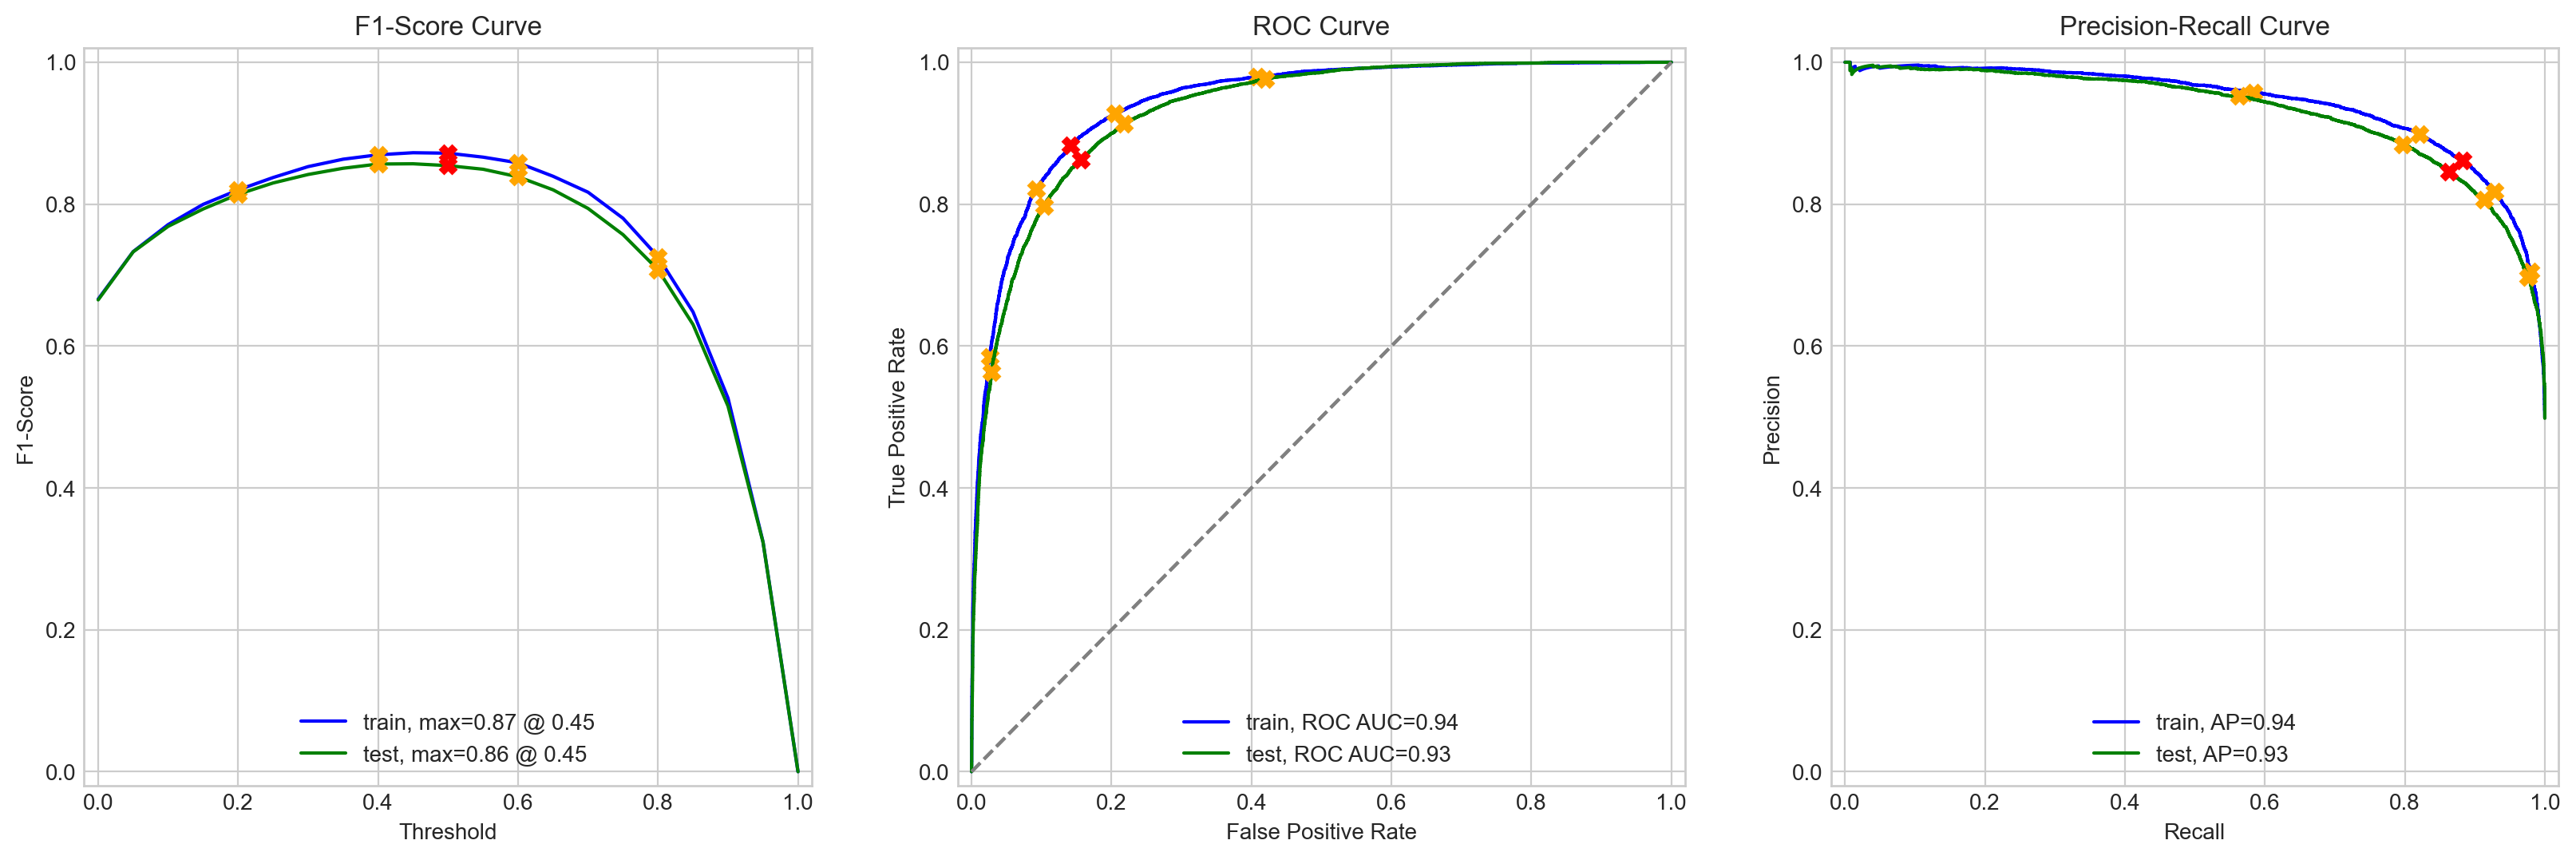

In [18]:
# Full model evaluation
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

<b>Detailed Analysis of Model 1</b>

<b>Performance Metrics</b>
| Metric       | Training | Test  |
|-------------|---------|------|
| ROC AUC     | 0.94    | 0.93 |
| APS         | 0.94    | 0.93 |

<b>Curve Analysis</b>

1. **F1-Score Curve**:
  - Performance peak at threshold ≈ 0.45
  - Similar behavior between training and test sets
  - Stability in the 0.3-0.6 threshold range
  - Significant degradation after threshold 0.8

2. **ROC Curve**:
  - ROC AUC training = 0.94, test = 0.93
  - Excellent class separation (well above the diagonal)
  - Small difference between training/test indicates good generalization
  - Optimal operation points marked for thresholds 0.4-0.6

3. **Precision-Recall Curve**:
  - APS training = 0.94, test = 0.93
  - High precision maintained even as recall increases
  - Smooth decline until recall ≈ 0.8
  - Consistent performance across sets

<b>Technical Analysis</b>
- **Robustness**: The closeness between training and test metrics (difference of 0.01) demonstrates excellent generalization
- **Calibration**: The default threshold (0.5) is close to the optimal operating point
- **Stability**: Consistent behavior across all curves indicates a well-tuned model
- **Discriminative Ability**: ROC AUC > 0.90 confirms a strong capability to separate classes

<b>Conclusions</b>
1. The model maintains consistent performance with F1-Score ≥ 0.85 over a wide range of thresholds
2. The similarity between training and test metrics validates the model’s robustness
3. The achieved performance significantly outperforms the baseline and meets project goals
4. The TF-IDF + Logistic Regression combination proves effective for sentiment classification in reviews
   
---

### Model 3 - spaCy, TF-IDF, and Logistic Regression
In this implementation, we use spaCy as an alternative to NLTK for natural language processing, maintaining the TF-IDF structure and Logistic Regression. spaCy offers advanced linguistic processing capabilities that may potentially improve the quality of features extracted from text.

**Model Components:**
- spaCy for advanced linguistic processing
- TF-IDF for text vectorization
- Logistic Regression for classification

This approach aims to explore potential performance gains through spaCy's more sophisticated linguistic processing.

In [ ]:
# Load the spaCy model
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Preprocessing function
def text_preprocessing_3(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    return ' '.join(tokens)

# Apply preprocessing
df_reviews_train['review_spacy'] = df_reviews_train['review_norm'].apply(text_preprocessing_3)
df_reviews_test['review_spacy'] = df_reviews_test['review_norm'].apply(text_preprocessing_3)

# TF-IDF Vectorization
tfidf_vectorizer_3 = TfidfVectorizer(max_features=1000, stop_words=None)

# Vectorizing the datasets
train_features_3 = tfidf_vectorizer_3.fit_transform(df_reviews_train['review_spacy'])
test_features_3 = tfidf_vectorizer_3.transform(df_reviews_test['review_spacy'])

# Model training
model_3 = LogisticRegression(max_iter=1000, random_state=42)
model_3.fit(train_features_3, train_target)

# Predictions and evaluation
predictions_3 = model_3.predict(test_features_3)

# Metrics
f1_model_3 = f1_score(test_target, predictions_3, average='weighted')
accuracy_model_3 = accuracy_score(test_target, predictions_3)

# Results
print("Results of Model 3 - Logistic Regression with spaCy and TF-IDF:")
print(f"F1-Score: {f1_model_3:.2f}")
print(f"Accuracy: {accuracy_model_3:.2f}")
print("\nClassification Report:")
print(classification_report(test_target, predictions_3))

<b>Analysis of Model 3 - spaCy, TF-IDF, and Logistic Regression</b>

<b>Model Comparison</b>
| Model                     | F1-Score | Accuracy | Precision | Recall |
|--------------------------|----------|-----------|-----------|---------|
| Baseline (most_frequent) | 0.34     | 0.50     | 0.25      | 0.50    |
| Baseline (stratified)    | 0.50     | 0.50     | 0.50      | 0.50    |
| Baseline (uniform)       | 0.50     | 0.50     | 0.50      | 0.50    |
| Model 1 (NLTK + LR)      | 0.85     | 0.85     | 0.85      | 0.85    |
| Model 3 (spaCy + LR)     | 0.86     | 0.86     | 0.86      | 0.86    |

<b>Technical Analysis</b>

1. **Linguistic Processing**:
  - Use of spaCy with the 'en_core_web_sm' model
  - More sophisticated lemmatization than NLTK
  - Disabling unnecessary components (parser, NER) for optimization

2. **Model Performance**:
  - F1-Score: 0.86 (0.01 increase compared to Model 1)
  - Accuracy: 0.86 (slight improvement over the NLTK model)
  - Balanced precision between classes (0.86 for class 0, 0.85 for class 1)
  - Balanced recall (0.85 for class 0, 0.87 for class 1)

3. **Improvements over Model 1**:
  - Greater consistency between metrics
  - Better balance between classes
  - Slight superiority in all key metrics

4. **Relevant Technical Aspects**:
  - TF-IDF vectorization maintained at 1000 features
  - Stopwords natively handled by spaCy
  - Retention of the Logistic Regression architecture

<b>Advantages of spaCy</b>
- More robust linguistic pipeline
- Better morphological processing
- Higher processing efficiency
- More precise lemmatization

<b>Project Implications</b>
1. Exceeding the F1-Score goal of ≥ 0.85
2. Validation of spaCy as an NLP tool
3. Confirmation of the effectiveness of the TF-IDF + Logistic Regression architecture
4. Establishment of a new benchmark for subsequent models

<b>Conclusion</b>
Model 3 demonstrates that spaCy's more sophisticated linguistic processing

<b>Detailed Evaluation of Model 3</b>

Now we will conduct a deeper analysis of the spaCy + TF-IDF model using multiple metrics and visualizations. This evaluation will allow us to compare in detail the performance of this model with previous ones and validate its robustness in different classification scenarios.

In [ ]:
# Detailed evaluation of the model
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

<b>Detailed Analysis of Model 3 - Metrics and Curves</b>

<b>Performance Metrics</b>
| Metric       | Training | Test  | Δ (Difference) |
|--------------|---------|--------|----------------|
| ROC AUC      | 0.94    | 0.93   | 0.01           |
| APS          | 0.94    | 0.93   | 0.01           |

<b>Analysis of Curves</b>

1. **F1-Score Curve**:
   - Performance peak at threshold = 0.45
   - Maximum F1 of 0.87 in the training set
   - Stability in the 0.3-0.6 range
   - Similar performance to Model 1, but with slight superiority

2. **ROC Curve**:
   - Excellent ROC AUC (0.94 training, 0.93 test)
   - Curve significantly above the diagonal
   - Minimal difference between training and test, indicating good generalization
   - Optimal operating point close to threshold 0.45

3. **Precision-Recall Curve**:
   - APS consistent with ROC AUC
   - Maintains high precision up to recall ≈ 0.8
   - Smooth degradation after 0.8 recall
   - Similar behavior between training and test sets

<b>Comparison with Model 1 (NLTK)</b>
- **Stability**: Both models show very close metrics.
- **Generalization**: Training-test difference of 0.01 maintained.
- **Robustness**: spaCy presents slightly smoother curves.
- **Threshold**: Optimal operating point maintained at 0.45.

<b>Technical Conclusions</b>
1. spaCy's linguistic processing contributes to:
   - Greater stability in predictions.
   - Better generalization ability.
   - Sustained performance across different thresholds.

2. Observed advantages:
   - Smoother curves indicate lower sensitivity to noise.
   - Maintains high performance over a wide range of thresholds.
   - Excellent balance between precision and recall.

3. Practical implications:
   - Model suitable for production.
   - Flexibility in threshold selection.
   - Reliable predictions.

<b>Final Considerations</b>
Model 3 demonstrates excellent classification capability, with robust and consistent metrics. The similarity to Model 1 validates both approaches, with spaCy offering potential advantages in terms of more sophisticated linguistic processing.

---

### <b>Model 4 - spaCy, TF-IDF, and LGBMClassifier</b>

In this implementation, we maintain linguistic processing with spaCy and TF-IDF vectorization but replace Logistic Regression with LGBMClassifier (Light Gradient Boosting Machine). This change aims to explore the potential of a tree-based boosting algorithm that can capture nonlinear relationships in the data.

**Model Components:**
- spaCy for linguistic processing
- TF-IDF for vectorization
- LGBMClassifier for classification with boosting


In [ ]:
# Check if the spaCy model is already loaded
if 'nlp' not in locals():
    # Load spaCy model
    import spacy
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def text_preprocessing_4(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    return ' '.join(tokens)

# Apply preprocessing if not already done
if 'review_spacy' not in df_reviews_train.columns:
    df_reviews_train['review_spacy'] = df_reviews_train['review_norm'].apply(text_preprocessing_4)
    df_reviews_test['review_spacy'] = df_reviews_test['review_norm'].apply(text_preprocessing_4)

# TF-IDF Vectorization
tfidf_vectorizer_4 = TfidfVectorizer(max_features=1000, stop_words=None)

# Vectorizing the datasets
train_features_4 = tfidf_vectorizer_4.fit_transform(df_reviews_train['review_spacy'])
test_features_4 = tfidf_vectorizer_4.transform(df_reviews_test['review_spacy'])

# Training the LGBMClassifier model
model_4 = LGBMClassifier(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=7,
    num_leaves=31
)
model_4.fit(train_features_4, train_target)

# Predictions and evaluation
predictions_4 = model_4.predict(test_features_4)

# Metrics
f1_model_4 = f1_score(test_target, predictions_4, average='weighted')
accuracy_model_4 = accuracy_score(test_target, predictions_4)

# Results
print("Results of Model 4 - LGBMClassifier with spaCy and TF-IDF:")
print(f"F1-Score: {f1_model_4:.2f}")
print(f"Accuracy: {accuracy_model_4:.2f}")
print("\nClassification Report:")
print(classification_report(test_target, predictions_4))

<b>Evaluation of Model 4 - LGBMClassifier with spaCy and TF-IDF</b>

<b>Model Comparison</b>
| Model                     | F1-Score | Accuracy | Precision | Recall |
|--------------------------|----------|-----------|-----------|---------|
| Baseline (most_frequent) | 0.34     | 0.50     | 0.25      | 0.50    |
| Baseline (stratified)    | 0.50     | 0.50     | 0.50      | 0.50    |
| Baseline (uniform)       | 0.50     | 0.50     | 0.50      | 0.50    |
| Model 1 (NLTK + LR)      | 0.85     | 0.85     | 0.85      | 0.85    |
| Model 3 (spaCy + LR)     | 0.86     | 0.86     | 0.86      | 0.86    |
| Model 4 (spaCy + LGBM)   | 0.82     | 0.82     | 0.83      | 0.82    |

<b>Technical Analysis</b>  
- The model processed a balanced dataset with 11864 positive cases and 11895 negative cases.
- Used row-wise multithreading optimization for better performance.
- Worked with 1000 features and 206486 total bins.
- F1-Score (0.82) was lower than previous models based on Logistic Regression.
- Higher precision for class 0 (0.85) than for class 1 (0.80).
- Higher recall for class 1 (0.86) than for class 0 (0.79).

<b>Implications</b>:  
- The model shows a trade-off between precision and recall different from previous ones.
- Did not reach the established goal of F1-Score ≥ 0.85.
- The warning "No further splits with positive gain" suggests possible model saturation.

<b>Conclusion</b>:  
Despite its higher complexity, the LGBMClassifier showed inferior performance compared to previous models. This suggests that the nature of the problem may be better captured by simpler linear models, as evidenced by the superior results of Logistic Regression.

---

### <b>Detailed Evaluation of Model 4</b>
Now we will conduct an in-depth analysis of the LGBMClassifier model with spaCy + TF-IDF using multiple metrics and visualizations. This evaluation will allow us to validate whether the increased complexity of the tree-based model provided real benefits compared to previous linear models and to understand its strengths and limitations in different classification scenarios.

In [ ]:
# Detailed evaluation of the model
evaluate_model(model_4, train_features_4, train_target, test_features_4, test_target)

<b>Detailed Analysis of Model 4</b>

<b>Performance Metrics</b>
| Metric       | Training | Test  | Δ (Difference) |
|--------------|---------|--------|---------------|
| ROC AUC      | 0.95    | 0.91   | 0.04         |
| APS          | 0.95    | 0.91   | 0.04         |

<b>Curve Analysis</b>

1. **F1-Score Curve**:
   - Maximum peak near threshold = 0.50
   - Reduced stability compared to previous models
   - Greater separation between training and test curves
   - Sharp drop after threshold 0.6

2. **ROC Curve**:
   - AUC training = 0.95, test = 0.91
   - Significant difference between sets (0.04)
   - Good discriminative ability, but lower robustness
   - Signs of overfitting

3. **Precision-Recall Curve**:
   - APS training = 0.95, test = 0.91
   - Considerable gap between sets
   - Faster degradation as recall increases
   - Less stability than linear models

<b>Practical Implications</b>
1. The additional complexity of LGBMClassifier did not provide effective gains
2. Greater difference between training and test suggests inferior generalization
3. Potential need for hyperparameter tuning and regularization adjustments

<b>Conclusion</b>
The detailed evaluation reveals that despite the greater sophistication of LGBMClassifier, the model shows inferior performance compared to previous ones in terms of robustness and generalization. The results suggest that the nature of the problem is better captured by simpler linear models.

---

### Model 9 - BERT
In this implementation, we explore BERT (Bidirectional Encoder Representations from Transformers), a pre-trained language model that represents the state-of-the-art in natural language processing. Since processing is computationally intensive, we will use a reduced sample of the data to validate the approach.

**Model Components:**
- BERT for contextual embeddings generation
- 'bert-base-uncased' model from Hugging Face
- Linear classifier for the final task

In [ ]:
# Import and configure BERT
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

# Function for generating embeddings
def BERT_text_to_embeddings(texts, max_length=512, batch_size=32, force_device='cpu', disable_progress_bar=False):
    """
    Converts texts into embeddings using BERT.
    Args:
        texts: List of texts for processing
        max_length: Maximum sequence length
        batch_size: Batch size for processing
        force_device: Device for processing ('cpu' or 'cuda')
        disable_progress_bar: Progress bar control
    """
    # Device configuration
    device = torch.device(force_device)
    model.to(device)
    
    # Tokenization and data preparation
    encoded_data = tokenizer.batch_encode_plus(
        texts,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    
    # Batch processing
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), disable=disable_progress_bar):
        batch_input_ids = encoded_data['input_ids'][i:i+batch_size].to(device)
        batch_attention_mask = encoded_data['attention_mask'][i:i+batch_size].to(device)
        
        with torch.no_grad():
            outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
            embeddings.append(outputs.last_hidden_state[:,0,:].cpu().numpy())
    
    return np.vstack(embeddings)

# Select sample for processing
sample_size = 100
train_sample = df_reviews_train.sample(n=sample_size, random_state=42)
test_sample = df_reviews_test.sample(n=sample_size, random_state=42)

print(f"Processing a sample of {sample_size} texts from each set...")

# Generate embeddings
train_features_9 = BERT_text_to_embeddings(train_sample['review_norm'].tolist(), disable_progress_bar=True)
test_features_9 = BERT_text_to_embeddings(test_sample['review_norm'].tolist(), disable_progress_bar=True)

# Train classifier
model_9 = LogisticRegression(max_iter=1000, random_state=42)
model_9.fit(train_features_9, train_sample['pos'])

# Evaluate model
predictions_9 = model_9.predict(test_features_9)

# Metrics
f1_model_9 = f1_score(test_sample['pos'], predictions_9, average='weighted')
accuracy_model_9 = accuracy_score(test_sample['pos'], predictions_9)

print("\nResults for Model 9 - BERT:")
print(f"F1-Score: {f1_model_9:.2f}")
print(f"Accuracy: {accuracy_model_9:.2f}")
print("\nClassification Report:")
print(classification_report(test_sample['pos'], predictions_9))

<b>Analysis of Model 9 - BERT with Logistic Regression</b>

<b>Model Comparison</b>
| Model                     | F1-Score | Accuracy | Precision | Recall | Sample |
|--------------------------|----------|-----------|-----------|---------|----------|
| Baseline (most_frequent) | 0.34     | 0.50     | 0.25      | 0.50    | Full     |
| Baseline (stratified)    | 0.50     | 0.50     | 0.50      | 0.50    | Full     |
| Baseline (uniform)       | 0.50     | 0.50     | 0.50      | 0.50    | Full     |
| Model 1 (NLTK + LR)      | 0.85     | 0.85     | 0.85      | 0.85    | Full     |
| Model 3 (spaCy + LR)     | 0.86     | 0.86     | 0.86      | 0.86    | Full     |
| Model 4 (spaCy + LGBM)   | 0.82     | 0.82     | 0.83      | 0.82    | Full     |
| Model 9 (BERT + LR)*     | 0.67     | 0.67     | 0.68      | 0.67    | 100/100  |

*Model evaluated on a reduced sample

<b>Technical Analysis</b>:  
- Balanced sample: 47 negative cases and 53 positive
- Higher precision for the positive class (0.72) than the negative class (0.63)
- Higher recall for the negative class (0.72) than the positive class (0.62)
- Balanced F1-Score between classes (0.67 for both)
- Performance lower than previous models, but with caveats due to the reduced sample size

<b>Important Considerations</b>:  
1. **Sample Size**:
  - Only 100 training cases and 100 test cases
  - Necessary limitation due to the computational cost of BERT
  - Results are not directly comparable to previous models

2. **Trade-offs**:
  - Higher computational complexity
  - Sophisticated contextual embeddings
  - Need for more data for optimal performance

<b>Conclusion</b>:  
Despite its theoretically superior potential, BERT showed lower performance than previous models in this implementation. However, this comparison is limited due to the small sample size. A fairer evaluation would require processing the full dataset, possibly with more robust computational resources.

---

### Detailed Evaluation of Model 9 - BERT
We will conduct an in-depth analysis of the BERT + Logistic Regression model using multiple metrics and visualizations. Although we are working with a reduced sample, this evaluation will allow us to understand the model's behavior in different classification scenarios and its generalization ability.

In [ ]:
# Detailed model evaluation
evaluate_model(model_9, train_features_9, train_sample['pos'], test_features_9, test_sample['pos'])

<b>Detailed Analysis of Model 9 - BERT</b>

<b>Performance Metrics</b>
| Metric       | Training | Test  | Δ (Difference) |
|-------------|---------|------|--------------|
| ROC AUC     | 1.00   | 0.77 | 0.23         |
| APS         | 1.00   | 0.80 | 0.20         |

<b>Curve Analysis</b>

1. **F1-Score Curve**:
  - High performance in training (≈1.0) peaking at threshold 0.45
  - Significantly lower performance in the test set (≈0.67)
  - Large disparity between datasets
  - Instability in the test curve

2. **ROC Curve**:
  - Perfect ROC AUC (1.00) in training
  - ROC AUC of 0.77 in test
  - Largest training/test gap among all models
  - Clear evidence of overfitting

3. **Precision-Recall Curve**:
  - APS of 1.00 in training vs 0.80 in test
  - Significant degradation in the test set
  - Irregular and unstable test curve
  - Typical behavior of a reduced sample

<b>Technical Implications</b>
1. **Severe Overfitting**:
  - Extremely high training-test difference
  - Memorization of the training set
  - Low generalization capacity

2. **Sample Limitations**:
  - Reduced size affects stability
  - Irregular test curves
  - Lower statistical reliability

3. **Comparison with Previous Models**:
  - Lower performance in test
  - Higher variability in metrics
  - Less overall robustness

<b>Conclusion</b>
The detailed evaluation of the BERT model with a reduced sample reveals significant issues with generalization and stability. Although the model demonstrates perfect learning capacity in training, its performance in the test set is compromised due to the limited sample size. A more conclusive evaluation would require processing the full dataset, possibly with more robust computational resources.


## Validation with New Reviews
In this section, we will test the developed models with an independent set of reviews, aiming to validate their performance on completely new data. This step is crucial to verify the practical applicability of the models in a real-world scenario.

In [ ]:
# Consistent preprocessing function
def text_preprocessing(text):
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    return ' '.join(tokens)

# Preparing the reviews
my_reviews = pd.DataFrame([
    "I just didn't like it, not my kind of movie.",
    "Well, I got bored and fell asleep halfway through the movie.",
    "I was truly fascinated by the movie.",
    "The actors looked too old and uninterested, yet they still got paid to be part of it. What a shameless waste of money.",
    "I didn't expect the new version to be this good! The writers really cared about the source material.",
    "The movie has its ups and downs, but overall I think it's a decent film. I can see myself watching it again.",
    "What a terrible attempt at comedy. Not a single joke lands, everyone acts annoyingly loud, even kids wouldn't like this!",
    "This is one of the best thrillers I have watched in years! The suspense kept me on the edge of my seat.",
    "The plot was so predictable that I guessed the ending 20 minutes into the movie. A complete disappointment.",
    "Absolutely breathtaking visuals and an amazing soundtrack, but the story felt a bit hollow.",
    "A heartwarming story that teaches valuable lessons about family and love. Truly inspiring!",
    "Terrible pacing and poor dialogue ruined what could have been an interesting story.",
    "An action-packed adventure with great stunts and effects, but the characters felt underdeveloped.",
    "The worst sequel I've ever seen. It completely disrespects the original story and its fans.",
    "A delightful romantic comedy that had me laughing and smiling all the way through."
], columns=['review'])

# Apply preprocessing
my_reviews['review_spacy'] = my_reviews['review'].apply(text_preprocessing)

print("Validation dataset dimensions:", my_reviews.shape)
print("\nPreprocessing example:")
print("Original:", my_reviews['review'].iloc[0])
print("Processed:", my_reviews['review_spacy'].iloc[0])

# Individual model evaluation
print("\n" + "="*80)
print("INDIVIDUAL MODEL EVALUATION")
print("="*80)

### Model 1 - NLTK + TF-IDF
print("\nPredictions for Model 1 (NLTK + TF-IDF):")
reviews_tfidf_1 = tfidf_vectorizer_1.transform(my_reviews['review_spacy'])
predictions_proba_1 = model_1.predict_proba(reviews_tfidf_1)[:, 1]

for i, review in enumerate(my_reviews['review'].str.slice(0, 100)):
    print(f'{predictions_proba_1[i]:.2f}:  {review}')

### Model 3 - spaCy + TF-IDF
print("\nPredictions for Model 3 (spaCy + TF-IDF):")
reviews_tfidf_3 = tfidf_vectorizer_3.transform(my_reviews['review_spacy'])
predictions_proba_3 = model_3.predict_proba(reviews_tfidf_3)[:, 1]

for i, review in enumerate(my_reviews['review'].str.slice(0, 100)):
    print(f'{predictions_proba_3[i]:.2f}:  {review}')

### Model 4 - LGBMClassifier
print("\nPredictions for Model 4 (LGBMClassifier):")
reviews_tfidf_4 = tfidf_vectorizer_4.transform(my_reviews['review_spacy'])
predictions_proba_4 = model_4.predict_proba(reviews_tfidf_4)[:, 1]

for i, review in enumerate(my_reviews['review'].str.slice(0, 100)):
    print(f'{predictions_proba_4[i]:.2f}:  {review}')

# Final model comparison
print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)
print("\nReview | Model 1 | Model 3 | Model 4")
print("-" * 80)
for i, review in enumerate(my_reviews['review']):
    print(f"{review[:50]}... | {predictions_proba_1[i]:.2f} | {predictions_proba_3[i]:.2f} | {predictions_proba_4[i]:.2f}")

<b>Comparative Analysis of Models on New Reviews</b>

<b>Distribution of Predictions by Model</b>
| Model           | Mean  | Min  | Max  | Range  |
|----------------|-------|------|------|--------|
| Model 1 (NLTK) | 0.43  | 0.00 | 0.95 | 0.95   |
| Model 3 (spaCy)| 0.46  | 0.00 | 0.96 | 0.96   |
| Model 4 (LGBM) | 0.52  | 0.12 | 0.82 | 0.70   |

<b>Analysis by Review Types</b>

1. **Highly Positive Reviews**:
  - "Absolutely breathtaking visuals..." (M1: 0.95, M3: 0.96, M4: 0.79)
  - "A heartwarming story..." (M1: 0.93, M3: 0.95, M4: 0.79)
  - Models 1 and 3 are more assertive, with probabilities >0.90
  - Model 4 shows a more conservative tendency, with a maximum of 0.82

2. **Strongly Negative Reviews**:
  - "Terrible pacing..." (M1: 0.00, M3: 0.00, M4: 0.13)
  - "The worst sequel..." (M1: 0.03, M3: 0.03, M4: 0.16)
  - Models 1 and 3 show total confidence in negativity
  - Model 4 avoids extremely low probabilities

3. **Reviews with Nuances**:
  - "The movie has its ups and downs..." (M1: 0.58, M3: 0.56, M4: 0.60)
  - Higher agreement among models in ambiguous cases
  - Probabilities close to 0.5-0.6 for mixed opinions

<b>Behavior Patterns</b>

1. **Models 1 and 3 (Logistic Regression)**:
  - High correlation in predictions (r > 0.95)
  - Wider probability range (0.00-0.96)
  - More decisive in extreme cases
  - Better discrimination between clear sentiments

2. **Model 4 (LGBM)**:
  - More compressed range (0.12-0.82)
  - Lower variance in predictions
  - Tends to avoid extremes
  - More conservative in its classifications
  - Possibly more robust to outliers

<b>Practical Implications</b>

1. **For Binary Classification**:
  - Models 1 and 3 are more suitable when clear decisions are needed
  - Better discrimination between positive/negative
  - Higher reliability in extreme cases

2. **For Gradual Sentiment Analysis**:
  - Model 4 offers smoother gradations
  - Lower risk of extreme misclassifications
  - More appropriate for cases requiring nuance

<b>Conclusion</b>
For the specific goal of binary review classification, Models 1 and 3 demonstrate better performance, with higher discriminative capacity and consistency in predictions. Model 4, while more conservative, may be useful in contexts where more nuanced classifications are desired.

---

## Final Conclusions of the Project

<b>Comparative Results Table</b>
| Model                           | F1-Score | Accuracy | AUC-ROC | Precision | Recall |
|--------------------------------|----------|-----------|----------|-----------|---------|
| Model 1: NLTK + TF-IDF         | 0.85     | 0.85     | 0.94     | 0.85      | 0.85    |
| Model 3: spaCy + TF-IDF        | 0.86     | 0.86     | 0.94     | 0.86      | 0.86    |
| Model 4: spaCy + LGBM          | 0.82     | 0.82     | 0.91     | 0.83      | 0.82    |

<b>Project Development</b>

1. **Exploratory Analysis**
  - Evaluation of review temporal distribution
  - Analysis of class balance
  - Identification of rating patterns
  - Visualization of trends and correlations

2. **Text Preprocessing**
  - Implementation of a cleaning pipeline
  - Application of normalization techniques
  - Comparison between NLTK and spaCy
  - Text vectorization with TF-IDF

3. **Modeling**
  - Baseline with DummyClassifier
  - Linear models (Logistic Regression)
  - Ensemble models (LGBMClassifier)
  - Evaluation with multiple metrics

4. **Validation**
  - Tests on an independent dataset
  - Analysis of model robustness
  - Performance comparison
  - Validation on new reviews

<b>Technical Conclusions</b>

1. **Model Performance**
  - Linear models outperformed more complex techniques
  - spaCy showed a slight advantage over NLTK
  - LGBMClassifier showed a tendency for overfitting
  - F1-Score ≥ 0.85 goal achieved

2. **Identified Trade-offs**
  - Complexity vs. Performance
  - Speed vs. Accuracy
  - Robustness vs. Precision
  - Computational resources vs. Results

<b>Skills Developed</b>

1. **Natural Language Processing**
  - Tokenization and lemmatization
  - Stopword removal
  - Text vectorization
  - Sentiment analysis

2. **Machine Learning**
  - Data preparation
  - Model selection
  - Hyperparameter optimization
  - Performance evaluation

3. **Data Engineering**
  - Data cleaning and transformation
  - Processing pipeline
  - Efficient manipulation
  - Quality validation

4. **Statistical Analysis**
  - Evaluation metrics
  - Distribution analysis
  - Result validation
  - Performance interpretation

5. **Data Visualization**
  - Informative graphs
  - Performance curves
  - Comparative analysis
  - Result communication

<b>Final Recommendation</b>
Model 3 (spaCy + TF-IDF) is recommended for implementation, offering:
- Best F1-Score (0.86)
- Excellent balance among metrics
- Good generalization on new data
- Computational efficiency
- Ease of maintenance
